Bootstrapping a yield curve
Short-term spot rates can be derived directly from various short-term securities, such
as zero-coupon bonds, T-bills, notes, and Eurodollar deposits. However, longerterm
spot rates are typically derived from the prices of long-term bonds through a
bootstrapping process, taking into account the spot rates of maturities corresponding
to the coupon payment date. After obtaining short-term and long-term spot rates, the
yield curve can then be constructed.
Let's illustrate the bootstrapping of the yield curve with an example. The following
table shows a list of bonds with different maturities and prices:
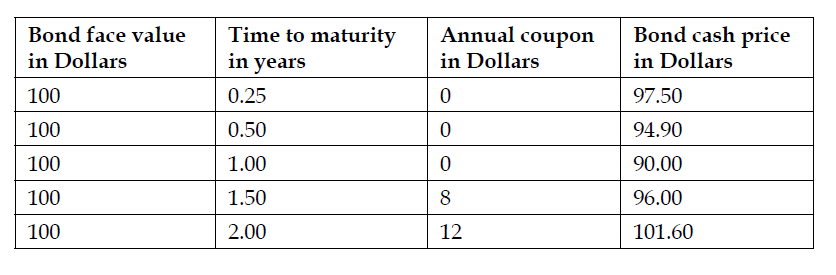

An investor of a 3-month zero-coupon bond today at $97.50 would earn an interest of
$2.50. The 3-month spot rate can be calculated as follows:

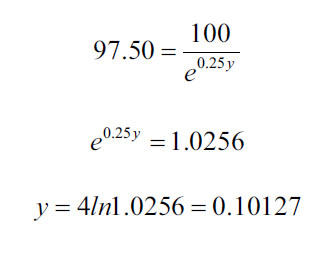

Thus, the 3-month zero rate is 10.127 percent with continuous compounding. The
spot rates of the zero-coupon bonds are computed in the following table:

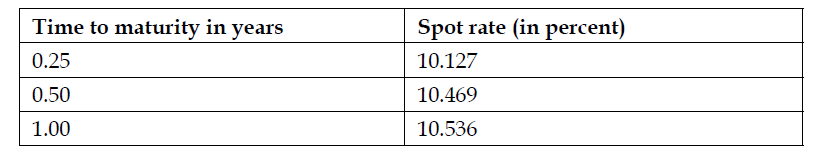

Using these spot rates, we can now price the 1.5-year bond as:

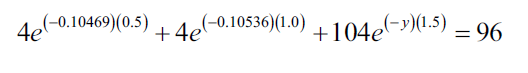

To solve for y, the spot rate for the 1.5-year bond and 2-year bond is 10.681 percent
and 10.808 percent respectively.
The following code is an implementation of bootstrapping a yield curve in Python.

In [3]:
"""
README
======
This file contains Python codes.
======
"""
 
""" Bootstrapping the yield curve """
import math
     
class BootstrapYieldCurve(object):
     
    def __init__(self):
        self.zero_rates = dict()  # Map each T to a zero rate
        self.instruments = dict()  # Map each T to an instrument
         
    def add_instrument(self, par, T, coup, price,
                       compounding_freq=2):
        """  Save instrument info by maturity """
        self.instruments[T] = (par, coup, price, compounding_freq)
     
    def get_zero_rates(self):
        """  Calculate a list of available zero rates """
        self.__bootstrap_zero_coupons__()
        self.__get_bond_spot_rates__()
        return [self.zero_rates[T] for T in self.get_maturities()]
         
    def get_maturities(self):
        """ Return sorted maturities from added instruments. """
        return sorted(self.instruments.keys())
         
    def __bootstrap_zero_coupons__(self):
        """ Get zero rates from zero coupon bonds """
        for T in self.instruments:
            (par, coup, price, freq) = self.instruments[T]
            if coup == 0:
                self.zero_rates[T] = \
                    self.zero_coupon_spot_rate(par, price, T)
                     
    def __get_bond_spot_rates__(self):
        """ Get spot rates for every marurity available """
        for T in self.get_maturities():
            instrument = self.instruments[T]
            (par, coup, price, freq) = instrument
 
            if coup != 0:
                self.zero_rates[T] = \
                    self.__calculate_bond_spot_rate__(
                        T, instrument)
                 
    def __calculate_bond_spot_rate__(self, T, instrument):
        """ Get spot rate of a bond by bootstrapping """
        try:
            (par, coup, price, freq) = instrument
            periods = T * freq  # Number of coupon payments
            value = price
            per_coupon = coup / freq  # Coupon per period
 
            for i in range(int(periods)-1):
                t = (i+1)/float(freq)
                spot_rate = self.zero_rates[t]
                discounted_coupon = per_coupon * \
                                    math.exp(-spot_rate*t)
                value -= discounted_coupon
 
            # Derive spot rate for a particular maturity
            last_period = int(periods)/float(freq)        
            spot_rate = -math.log(value /
                                  (par+per_coupon))/last_period
            return spot_rate
 
        except:
            print(("Error: spot rate not found for T=%s" % t))
             
    def zero_coupon_spot_rate(self, par, price, T):
        """ Get zero rate of a zero coupon bond """
        spot_rate = math.log(par/price)/T
        return spot_rate
 
 


We can instantiate the BootstrapYieldCurve class, and add each bond's
information from the preceding table:

In [4]:
if __name__ == "__main__":
    yield_curve = BootstrapYieldCurve()
    yield_curve.add_instrument(100, 0.25, 0., 97.5)
    yield_curve.add_instrument(100, 0.5, 0., 94.9)
    yield_curve.add_instrument(100, 1.0, 0., 90.)
    yield_curve.add_instrument(100, 1.5, 8, 96., 2)
    yield_curve.add_instrument(100, 2., 12, 101.6, 2)
    y = yield_curve.get_zero_rates()
    x = yield_curve.get_maturities()
 
   

Calling the get_zero_rates method in the class returns a list of spot rates in the
same order as the maturities, which are stored in the y and x variables respectively.
When we plot x and y on a graph, we get the following output:

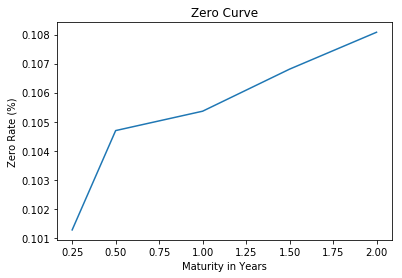

In [6]:
    import matplotlib.pyplot as plt
    plt.plot(x, y)
    plt.title("Zero Curve")
    plt.ylabel("Zero Rate (%)")
    plt.xlabel("Maturity in Years")
    plt.show()

In a normal yield curve environment, where the interest rates increase as the
maturities increase, we can obtain an upward-sloping yield curve.